In [1]:
from context import *
from stable_baselines3 import PPO,A2C,SAC,TD3,DQN,DDPG
from stable_baselines3.common.save_util import load_from_zip_file
from stable_baselines3.common.monitor import Monitor
import torch as th
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv

from pprint import pprint
import enum

import rlrom.wrappers.stl_wrapper
import stlrom
from rlrom.envs import *
import rlrom.utils

import matplotlib.pyplot as plt


pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-04-07 09:22:16.696726: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 09:22:16.704826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-07 09:22:16.713708: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Atte

In [3]:
class EnvMode(enum.Enum):
    VANILLA=0
    STL=1
    
def make_env(train=True, env_mode=EnvMode.VANILLA):
    if train:
        env = gym.make("highway-fast-v0")
    else:
        env = gym.make("highway-v0", render_mode='human')

    env.unwrapped.configure({
            "observation": {"type": "Kinematics"},
                "action": {
                    "type": "DiscreteMetaAction",
                },
                "lanes_count": 4,
                "vehicles_count": 50,
                "controlled_vehicles": 1,
                "initial_lane_id": None,
                "duration": 100,  # [s]
                "ego_spacing": 2,
                "vehicles_density": 1,
                "collision_reward": -.1,  # The reward received when colliding with a vehicle.
                "right_lane_reward": 0,  # The reward received when driving on the right-most lanes, linearly mapped to
                # zero for other lanes.
                "high_speed_reward": 1.,  # The reward received when driving at full speed, linearly mapped to zero for
                # lower speeds according to config["reward_speed_range"].
                "lane_change_reward": 0,  # The reward received at each lane change action.
                "reward_speed_range": [20, 30],
                "normalize_reward": True,
                "offroad_terminal": False,        
    })

    if env_mode==EnvMode.STL:
        cfg = cfg_envs['highway-env']
        driver= stlrom.STLDriver()
        driver.parse_string(cfg['specs'])
        env = rlrom.wrappers.stl_wrapper.STLWrapper(env,driver,signals_map=cfg)

    return env

# Training vanilla highway-env

In [ ]:
neurons = 128

policy_kwargs = dict(
    #activation_fn=th.nn.ReLU,
    net_arch=dict(pi=[neurons, neurons], qf=[neurons, neurons])
)



In [ ]:
n_cpu = 12
batch_size = 64
#env = make_env()
vec_env = make_vec_env(make_env, n_envs=n_cpu, vec_env_cls=SubprocVecEnv)
model = PPO(
     "MlpPolicy",
     vec_env,
     policy_kwargs=policy_kwargs,
     n_steps=batch_size * 12 // n_cpu,
     batch_size=batch_size,
     n_epochs=10,
     learning_rate=5e-4,
     gamma=0.99,
     verbose=1,
     tensorboard_log="./highway_ppo/"
)



In [ ]:
# Train the agent
model.learn(
    total_timesteps=50_000,
    progress_bar=True
)


In [ ]:
model.save('ppo_model')

# Testing

In [4]:
model = PPO.load('ppo_model.zip')

In [12]:
env = make_env(train=False,env_mode=EnvMode.STL)
obs, info = env.reset()
wobs = env.wrapped_obs
for _ in range(100):    
    action, _states = model.predict(wobs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)    
    wobs= env.wrapped_obs    
env.close()

In [7]:
lay = """
action
ego_x, car1_x
"""
lay = utils.get_layout_from_string(lay)


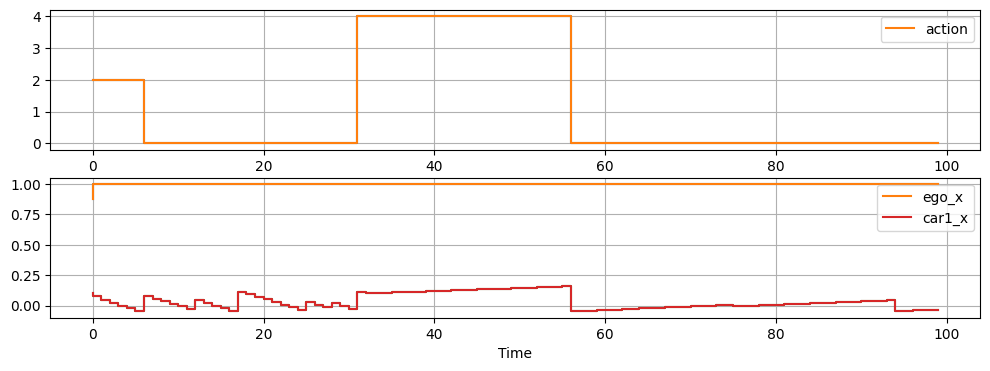

In [18]:
width = 12
height = 4
fig, axs = plt.subplots(len(lay),1, figsize=(width, height))
idx_ax =0
for sig_list in lay:
    for sig in sig_list:
        env.plot_signal(sig, axs[idx_ax])
    idx_ax +=1

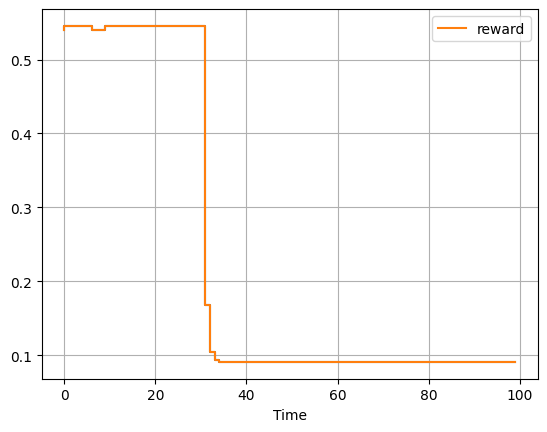

In [16]:

fig, ax = plt.subplots()
env.plot_signal("reward", ax)
# Show the plot with interactive features
plt.show()


In [ ]:
def get_fig(env, signals_layout):
    lay = utils.get_layout_from_string(signals_layout)
    status = "Plot ok. Hit reset on top right if not visible."            
    #f= figure(height=200)
    figs = []
    colors = itertools.cycle(palette)    
    for signal_list in enumerate(lay):
        f=None
        for signal in signal_list[1]:                
            #try: 
                color=colors.__next__()                    
                #tr_idx = self.trace_idx
                print(signal.strip())
                if signal.strip().startswith("set_trace_idx(") or signal.strip().startswith("_tr("):            
                    tr_idx = int(signal.split('(')[1][:-1])                         
                    env.set_current_trace(tr_idx)                        
                else: 
                    if f is None:
                        if figs == []:
                            f = figure(height=200)
                        else:
                            f = figure(height=200, x_range=figs[0][0].x_range)
                        figs.append([f])
                    env.plot_signal(f, signal, color=color)
            #except:
            #     status = "Warning: error getting values for " + signal
    fig = gridplot(figs, sizing_mode='stretch_width')        
    
    return fig, status
                

In [ ]:
def db_plot_signal(self, signal, fig=None,label=None,  color=None, online=False, horizon=0):
    # signal should be part of the "signal" declaration or a valid formula id 
     
        if self.stl_driver.data == []:
            raise ValueError("No data to plot.")
                 
        time = self.get_time()

        if signal in self.signals_map:
            signal_index = list(self.signals_map.keys()).index(signal)+1        
            sig_values = [s[signal_index] for s in self.stl_driver.data]
            if label is None:
                label=signal
        elif signal in self.formulas:
            sig_values = self.get_rob(signal, online=online,horizon=horizon)
            signal_index = self.formulas.index(signal)+len(self.signals_map)        
            if label is None:
                label=signal
        elif isinstance(signal, np.ndarray) and signal.shape == (len(self.get_time()),):
            sig_values = signal
        elif isinstance(signal, stlrom.Signal):
            pass
        else:
            try:
                sig_values = self.get_rob(signal, online=online,horizon=horizon)
            except Exception as e:
               raise ValueError(f"Name '{signal}' not in signals_map nor in parsed formulas")

        if fig is None:
            fig = figure(height=200)

        fig.xaxis.axis_label = "Time"
        print(sig_values)
        fig.step(time, sig_values)            
        
        
        return fig


In [ ]:
f = figure(height=200)
db_plot_signal(env, "ego_x")


In [ ]:
f.

In [ ]:
fig, status = get_fig(env, lay)